# Documentation

**Author:** Anirudh  
**Date:** 10/05/2025

### Details:
- **Modeling:** Using interaction models to capture the influence of sleep over cognitive tests and mri brain volumes, controlling for sociodemographic features.
  - The formula is : "cognitive_function" ~ C(group) * age + C(gender) + C(race) + C(ethnicity) + C(apoe4)" where group is the interaction term (sleep variable)

In [19]:
from itertools import product
import statsmodels.formula.api as smf

from collections import defaultdict
import statsmodels.api as sm

import pandas as pd

pd.set_option("display.width", 100)

import matplotlib.pyplot as plt

from statsmodels.formula.api import ols

from statsmodels.graphics.api import interaction_plot, abline_plot

from statsmodels.stats.anova import anova_lm

import numpy as np 

import seaborn as sns 

In [2]:
volumes_data = pd.read_csv("Updated_merge.csv")
sleep_data = pd.read_csv("Updated_sleep.csv")
bmi = pd.read_csv("Updated_BMI.csv")

In [3]:
volumes_data = pd.merge(volumes_data, bmi, on='RID')

In [4]:
merge = pd.merge(volumes_data, sleep_data, on=['RID', 'VISCODE'])

In [5]:
merge = merge.drop(['MHDESC'], axis=1)

In [8]:
cognitive_outcomes = ['ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2']
sleep_vars = ['NPIK', 'NPIKSEV', 'Sleep_Apnea', 'Restless_Legs',
              'Insomnia', 'Sleep_Disturbance_Other']
mri_outcomes = [
    "RightEntorhinal",
    "RightTemporalPole",
    "RightParahippocampal",
    "RightInferiorTemporal",
    "RightMiddleTemporal",
    "RightFusiform",
    "RightInferiorParietal",
    "RightIsthmusCingulate",
    "RightBankssts",
    "RightPrecuneus",
    "RightHippocampus",
    "RightAmygdala",
    "RightAccumbensArea",
    "RightMedialOrbitofrontal",
    "RightPallidum",
    "RightCaudalMiddleFrontal",
    "RightPutamen",
    "RightRostralAnteriorCingulate",
    "RightParacentral",
    "RightPrecentral",
    "RightLingual",
    "LeftEntorhinal",
    "LeftHippocampus",
    "LeftFusiform",
    "LeftMiddleTemporal",
    "LeftParacentral",
    "RightInferiorLateralVentricle",
    "LeftInferiorLateralVentricle",
    "RightLateralVentricle",
    "LeftLateralVentricle",
    "Icv",
]

In [9]:
interaction_results = {
    'cognitive': defaultdict(list),
    'mri': defaultdict(list)
}

In [10]:
model_counter = 1

In [14]:
def save_interaction_results(result, outcome, sleep_var, interaction_var, domain):
    records = []
    for predictor in result.params.index:
        records.append({
            'Model_ID': f"model_{model_counter}",
            'Outcome': outcome,
            'Sleep_Variable': sleep_var,
            'Interaction_Variable': interaction_var,
            'Feature': predictor,
            'Coefficient': result.params.get(predictor, float('nan')),
            'P-Value': result.pvalues.get(predictor, float('nan')),
            'F-Statistic': result.fvalue,
            'P-Value (F)': result.f_pvalue,
            'Type': domain
        })
    return records

In [11]:
from sklearn.preprocessing import StandardScaler

continuous_vars = (
    cognitive_outcomes + sleep_vars +
    mri_outcomes + ['BMI', 'Adjusted_Age', 'ICV']
)
merge_scaled = merge.copy()
scaler = StandardScaler()

merge_scaled[continuous_vars] = scaler.fit_transform(
    merge_scaled[continuous_vars])

In [12]:
categorical_vars = ['DX','PTRACCAT']
merge_scaled = pd.get_dummies(
    merge_scaled, columns=categorical_vars, drop_first=True)

In [13]:
feature_rename_map = {
    'DX_1': 'Dx_AD',
    'DX_2': 'Dx_MCI',
    'PTGENDER': 'Sex',
    'PTEDUCAT': 'Education',
    'AGE': 'Age',
    'PTRACCAT_1': 'Black',
    'PTRACCAT_2': 'White',
    'PTETHCAT': 'Ethnicity',
    'PTMARRY': 'Marital Status',
    'APOE4': 'APOE4',
    'BMI': 'BMI',
    'MH19OTHR': 'Other_MH',
    'MH2NEURL': 'Neurological',
    'MH4CARD': 'Cardiovascular',
    'MH5RESP': 'Respiratory',
    'MHPSYCH': 'Psychiatric'
}

In [14]:
mh_cols = ["MH19OTHR", "MH2NEURL", "MH4CARD", "MH5RESP", "MHPSYCH"]
merge_scaled["MH"] = merge_scaled[mh_cols].sum(axis=1)

In [ ]:
model1_preds = ['Adjusted_Age', 'PTEDUCAT',
                    'PTETHCAT',
                    'PTGENDER',
                    'PTMARRY',
                    'PTRACCAT_1',
                    'PTRACCAT_2',
                    'DX_1',
                    'DX_2']
model2_preds = model1_preds + ['APOE4', 'BMI', 'MH']

In [17]:
merge_scaled

,VISCODE,RID,Brainstem,CorpusCallosumAnterior,CorpusCallosumCentral,CorpusCallosumMidAnterior,CorpusCallosumMidPosterior,CorpusCallosumPosterior,Csf,RightParacentral,...,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other,Sleep_Quality,DX_1,DX_2,PTRACCAT_1,PTRACCAT_2,MH
0,0,3,24577.0,790.0,375.0,341.0,307.0,735.0,1905.0,0.462697,...,-0.244742,-0.124757,-0.15175,-0.087875,2,1,0,0,1,1
1,1,3,23784.0,774.0,378.0,358.0,314.0,701.0,2022.0,0.347091,...,-0.244742,-0.124757,-0.15175,-0.087875,2,1,0,0,1,1
2,2,3,23759.0,763.0,369.0,323.0,307.0,721.0,2176.0,-0.079763,...,-0.244742,-0.124757,-0.15175,-0.087875,2,1,0,0,1,1
3,3,3,23324.0,717.0,351.0,317.0,319.0,707.0,2023.0,0.391555,...,-0.244742,-0.124757,-0.15175,-0.087875,2,1,0,0,1,1
4,0,5,22015.0,960.0,451.0,470.0,368.0,1136.0,1423.0,-0.741387,...,-0.244742,-0.124757,-0.15175,-0.087875,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,3,1425,18719.0,477.0,291.0,267.0,282.0,740.0,1191.0,-0.583095,...,-0.244742,-0.124757,-0.15175,-0.087875,2,0,1,0,1,2
2084,0,1427,18408.0,920.0,365.0,418.0,395.0,938.0,1534.0,-0.280740,...,-0.244742,-0.124757,-0.15175,-0.087875,2,0,1,0,1,2
2085,1,1427,18996.0,1001.0,392.0,438.0,348.0,902.0,1446.0,0.014500,...,-0.244742,-0.124757,-0.15175,-0.087875,2,0,1,0,1,2
2086,2,1427,18506.0,917.0,363.0,388.0,391.0,937.0,1470.0,0.130106,...,-0.244742,-0.124757,-0.15175,-0.087875,0,1,0,0,1,2


In [20]:
def fit_lmm_interaction_explicit(df, outcomes, sleep_vars, predictors, model_label):
    results = []

    df = df.copy()
    df["Intercept"] = 1.0

    for sleep, outcome in product(sleep_vars, outcomes):
        try:
            fe_vars = [sleep] + predictors + \
                [f"{sleep}:{pred}" for pred in predictors]
            df_interact = df.copy()

            for pred in predictors:
                interact_term = f"{sleep}:{pred}"
                df_interact[interact_term] = df_interact[sleep] * \
                    df_interact[pred]

            exog = df_interact[["Intercept"] + fe_vars]
            endog = df_interact[outcome]
            exog_re = df_interact[["Intercept"]] 

            model = sm.MixedLM(endog, exog, groups=df["RID"], exog_re=exog_re)
            result = model.fit(reml=False)

            for term in fe_vars:
                if f"{sleep}:" in term:
                    results.append({
                        "Model": model_label,
                        "Sleep_Var": sleep,
                        "Outcome": outcome,
                        "Interaction_Term": term,
                        "Coef": result.params[term],
                        "P-Value": result.pvalues[term]
                    })

        except Exception as e:
            print(
                f"Model failed for {sleep} x {outcome} in {model_label}: {e}")
            continue

    return pd.DataFrame(results)

In [22]:
mri_model1 = fit_lmm_interaction_explicit(
    merge_scaled, mri_outcomes, sleep_vars, model1_preds, 'Model1_MRI')
mri_model2 = fit_lmm_interaction_explicit(
    merge_scaled, mri_outcomes, sleep_vars, model2_preds, 'Model2_MRI')
cog_model1 = fit_lmm_interaction_explicit(
    merge_scaled, cognitive_outcomes, sleep_vars, model1_preds, 'Model1_Cog')
cog_model2 = fit_lmm_interaction_explicit(
    merge_scaled, cognitive_outcomes, sleep_vars, model2_preds, 'Model2_Cog')

Model failed for Restless_Legs x LeftInferiorLateralVentricle in Model1_MRI: Singular matrix


In [25]:
merge_scaled[['Restless_Legs', 'LeftInferiorLateralVentricle']].isna().sum()

Restless_Legs                   0
LeftInferiorLateralVentricle    0
dtype: int64

In [27]:
interaction_results = pd.concat(
    [mri_model1, mri_model2, cog_model1, cog_model2], ignore_index=True)

In [28]:
interaction_results

,Model,Sleep_Var,Outcome,Interaction_Term,Coef,P-Value
0,Model1_MRI,NPIK,RightEntorhinal,NPIK:Adjusted_Age,0.000946,0.945351
1,Model1_MRI,NPIK,RightEntorhinal,NPIK:PTEDUCAT,-0.000442,0.932515
2,Model1_MRI,NPIK,RightEntorhinal,NPIK:PTETHCAT,-0.041025,0.734468
3,Model1_MRI,NPIK,RightEntorhinal,NPIK:PTGENDER,0.018181,0.510618
4,Model1_MRI,NPIK,RightEntorhinal,NPIK:PTMARRY,-0.014719,0.272632
...,...,...,...,...,...,...
4522,Model2_Cog,Sleep_Disturbance_Other,ADNI_EF2,Sleep_Disturbance_Other:DX_1,-0.763544,NaN
4523,Model2_Cog,Sleep_Disturbance_Other,ADNI_EF2,Sleep_Disturbance_Other:DX_2,-0.537408,NaN
4524,Model2_Cog,Sleep_Disturbance_Other,ADNI_EF2,Sleep_Disturbance_Other:APOE4,-0.460555,NaN
4525,Model2_Cog,Sleep_Disturbance_Other,ADNI_EF2,Sleep_Disturbance_Other:BMI,-0.231295,NaN


In [34]:
import math
def plot_interaction_lmm(df, model='Model1_MRI', domain='MRI', n_cols=2):
    df = df[df['Model'] == model].copy()

    df['Sleep_Variable'] = df['Interaction_Term'].str.extract(r'(^.+?):')[0]
    df['Feature'] = df['Interaction_Term'].str.split(':').str[1]

    sleep_vars = df['Sleep_Variable'].unique()
    n_plots = len(sleep_vars)
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(
        n_cols*6, n_rows*5), squeeze=False)

    for idx, sleep_var in enumerate(sleep_vars):
        row, col = divmod(idx, n_cols)
        ax = axes[row][col]

        df_plot = df[df['Sleep_Variable'] == sleep_var]

        df_others = df_plot[df_plot['Feature'] != sleep_var]
        sns.barplot(
            data=df_others,
            x='Coef',
            y='Outcome',
            hue='Feature',
            dodge=True,
            palette='tab10',
            ax=ax,
            alpha=0.7
        )

        df_sleep = df_plot[df_plot['Feature'] == sleep_var]
        if not df_sleep.empty:
            sns.barplot(
                data=df_sleep,
                x='Coef',
                y='Outcome',
                color='crimson',
                ax=ax,
                label=sleep_var,
                dodge=True,
                alpha=0.5,
                linewidth=2,
                edgecolor='black'
            )

        ax.axvline(x=0, color='red', linestyle='--')
        ax.set_title(f'{sleep_var}', fontsize=12)
        ax.set_xlabel('Coefficient')
        ax.set_ylabel('Outcome')
        ax.legend_.remove()

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels[:-1],
               bbox_to_anchor=(1.02, 1), loc='upper left')
    fig.legend([handles[-1]], ['Sleep Variable'], title='Predictor',
               bbox_to_anchor=(1.02, 1.05), loc='upper left')
    fig.suptitle(
        f'LMM Interaction Coefficients: Sleep x {domain} Outcomes', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.88, 0.97])
    plt.show()

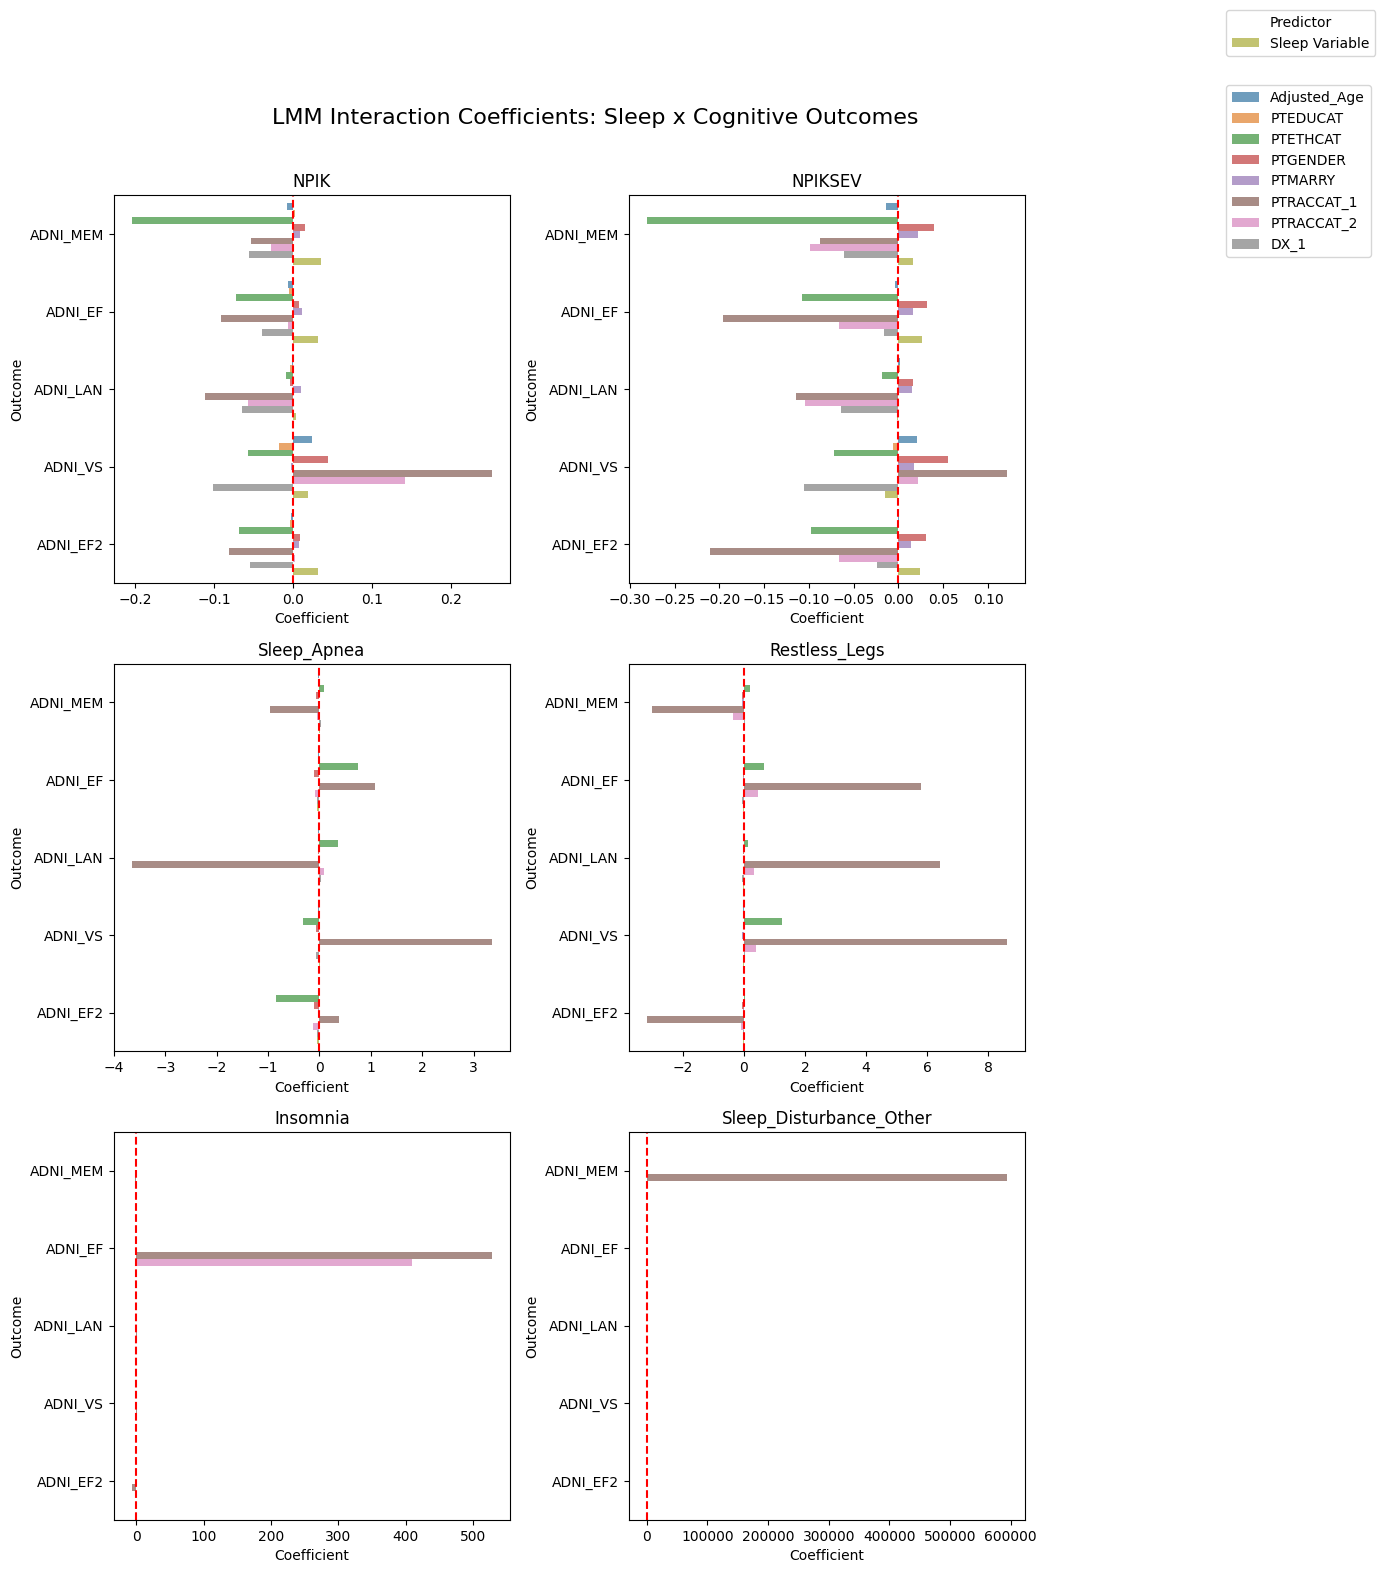

In [35]:
plot_interaction_lmm(interaction_results,
                     model='Model1_Cog', domain='Cognitive')

In [39]:
flat_mri = interaction_results[interaction_results['Model'] == 'Model1_MRI']

In [41]:
flat_mri

,Model,Sleep_Var,Outcome,Interaction_Term,Coef,P-Value
0,Model1_MRI,NPIK,RightEntorhinal,NPIK:Adjusted_Age,0.000946,0.945351
1,Model1_MRI,NPIK,RightEntorhinal,NPIK:PTEDUCAT,-0.000442,0.932515
2,Model1_MRI,NPIK,RightEntorhinal,NPIK:PTETHCAT,-0.041025,0.734468
3,Model1_MRI,NPIK,RightEntorhinal,NPIK:PTGENDER,0.018181,0.510618
4,Model1_MRI,NPIK,RightEntorhinal,NPIK:PTMARRY,-0.014719,0.272632
...,...,...,...,...,...,...
1660,Model1_MRI,Sleep_Disturbance_Other,Icv,Sleep_Disturbance_Other:PTMARRY,-3.013146,NaN
1661,Model1_MRI,Sleep_Disturbance_Other,Icv,Sleep_Disturbance_Other:PTRACCAT_1,613968.521560,0.994838
1662,Model1_MRI,Sleep_Disturbance_Other,Icv,Sleep_Disturbance_Other:PTRACCAT_2,-5.639660,0.999986
1663,Model1_MRI,Sleep_Disturbance_Other,Icv,Sleep_Disturbance_Other:DX_1,39.665754,0.999959


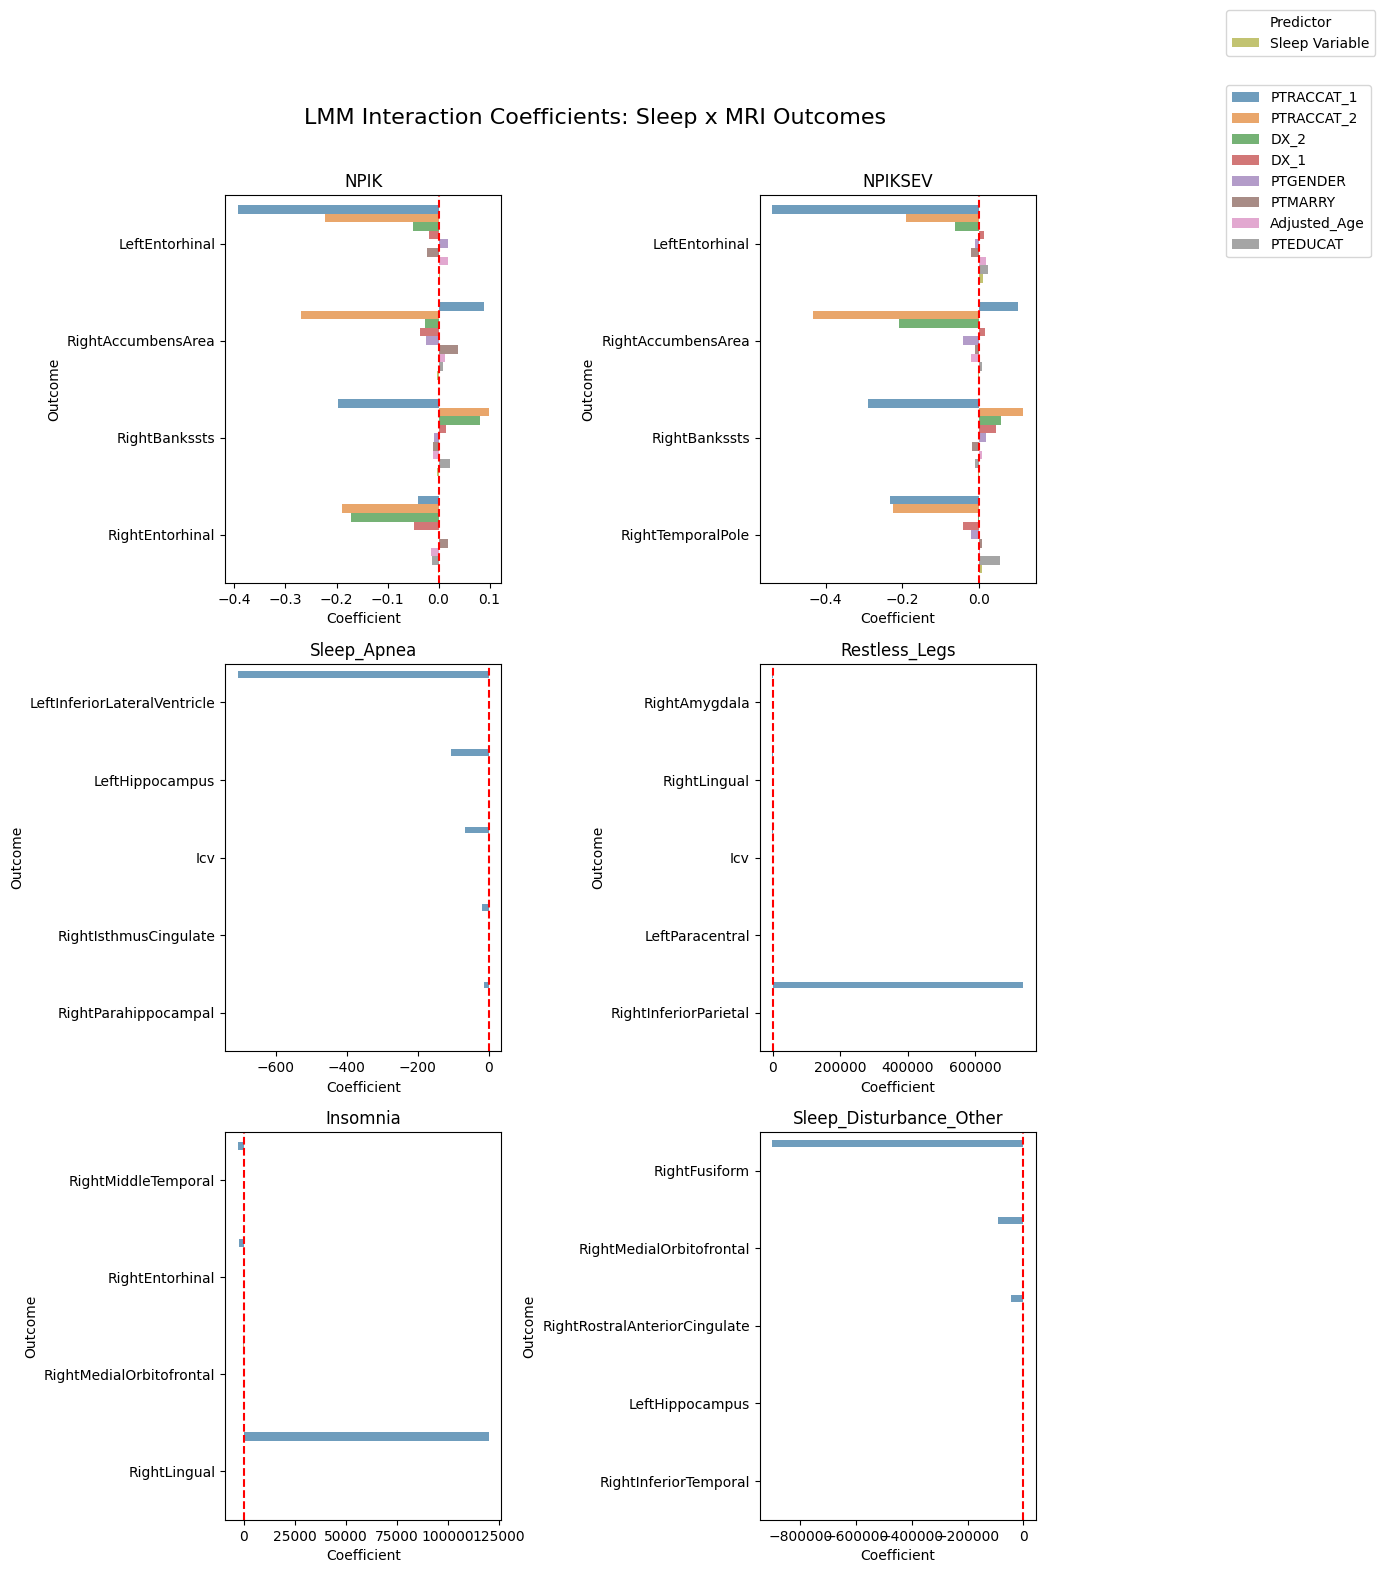

In [43]:
all_df_top = []

for sleep_var in flat_mri['Sleep_Var'].unique():
    df_plot = flat_mri[(flat_mri['Sleep_Var'] == sleep_var)]

    top_outcomes = (
        df_plot[(df_plot['Sleep_Var'] == sleep_var)]
        .sort_values(by='Coef')
        .set_index('Outcome')['Coef']
        .abs()
        .head(5)
        .index
    )
    df_top = df_plot[df_plot['Outcome'].isin(top_outcomes)]
    all_df_top.append(df_top.sort_values(by='Coef'))

df_top_all = pd.concat(all_df_top, ignore_index=True)

plot_interaction_lmm(df_top_all, model='Model1_MRI', domain='MRI')

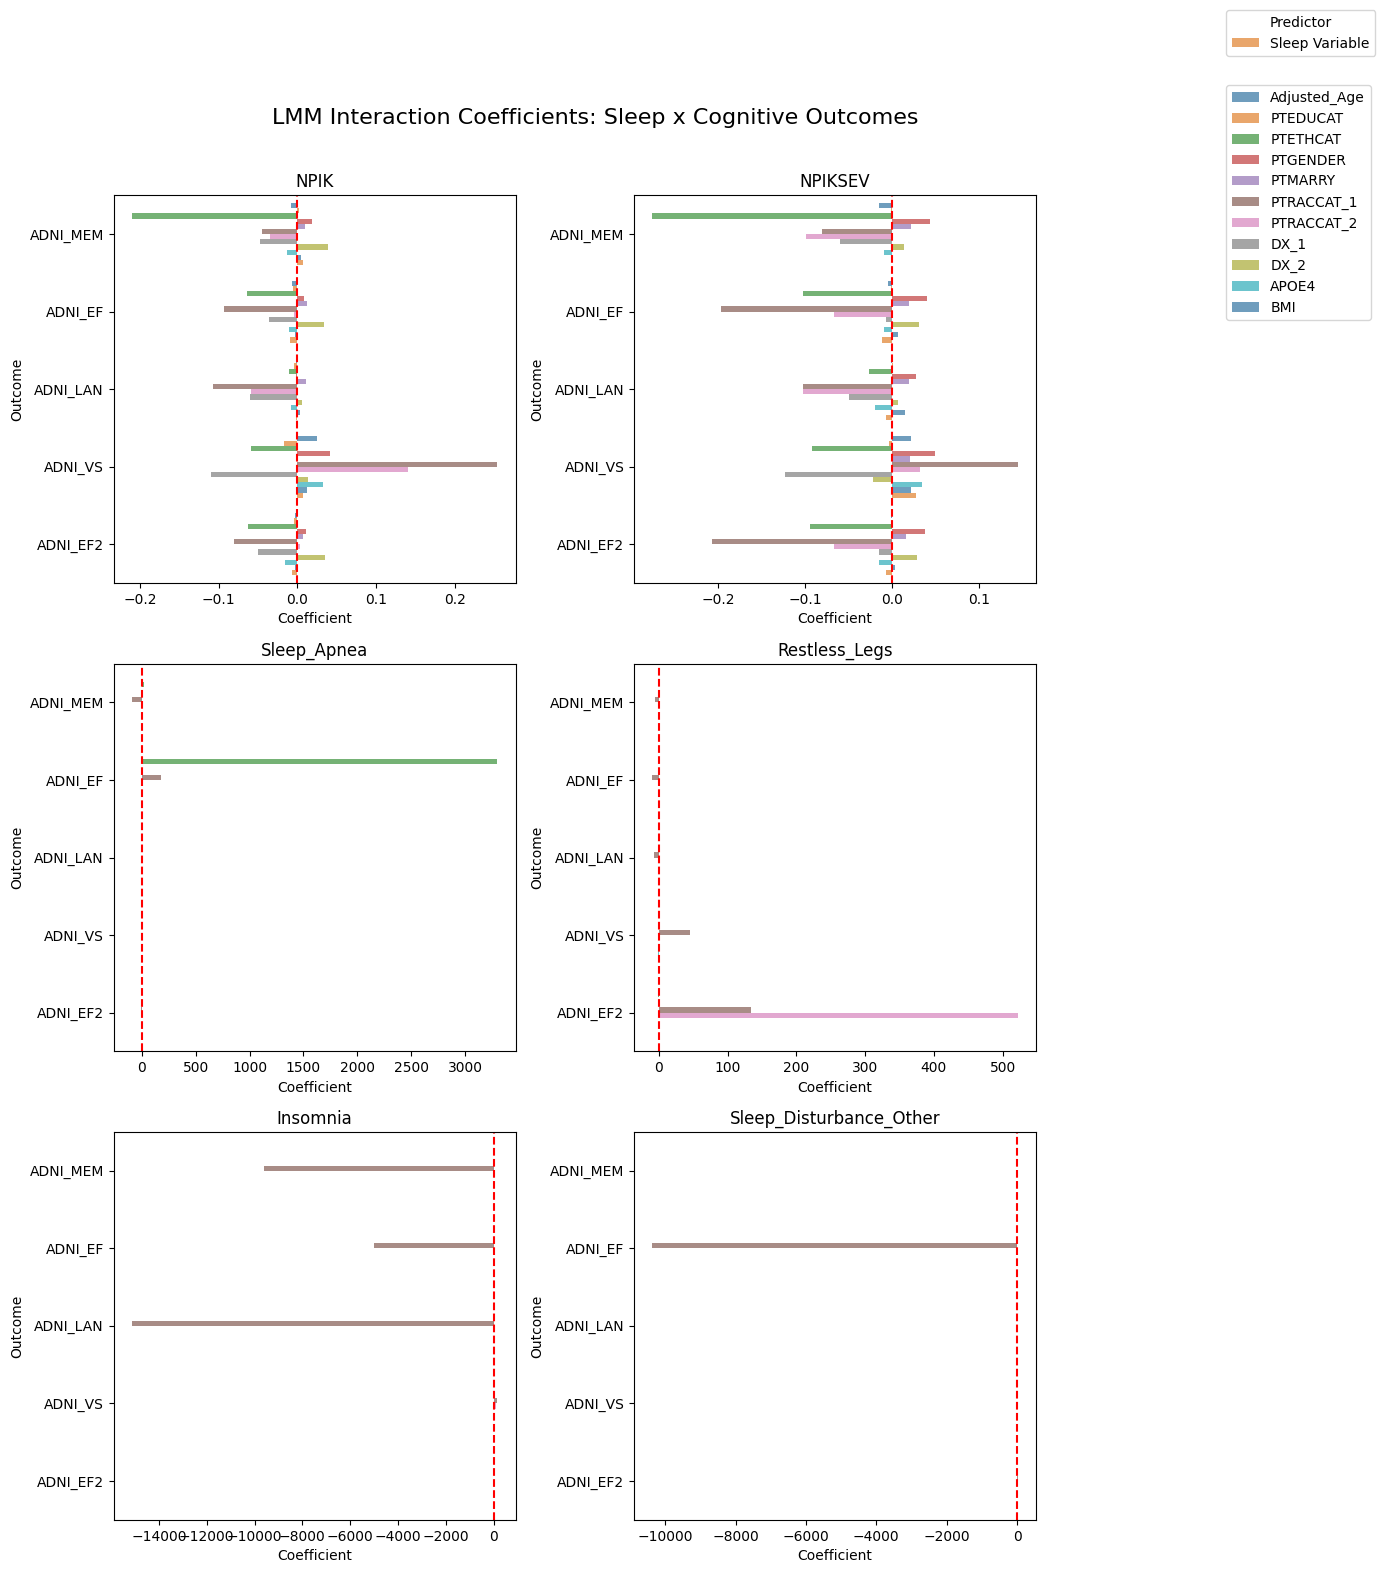

In [44]:
plot_interaction_lmm(interaction_results,
                     model='Model2_Cog', domain='Cognitive')

In [46]:
flat_mri = interaction_results[interaction_results['Model'] == 'Model2_MRI']

In [47]:
all_df_top = []

for sleep_var in flat_mri['Sleep_Var'].unique():
    df_plot = flat_mri[(flat_mri['Sleep_Var'] == sleep_var)]

    top_outcomes = (
        df_plot[(df_plot['Sleep_Var'] == sleep_var)]
        .sort_values(by='Coef')
        .set_index('Outcome')['Coef']
        .abs()
        .head(5)
        .index
    )
    df_top = df_plot[df_plot['Outcome'].isin(top_outcomes)]
    all_df_top.append(df_top.sort_values(by='Coef'))

df_top_all = pd.concat(all_df_top, ignore_index=True)

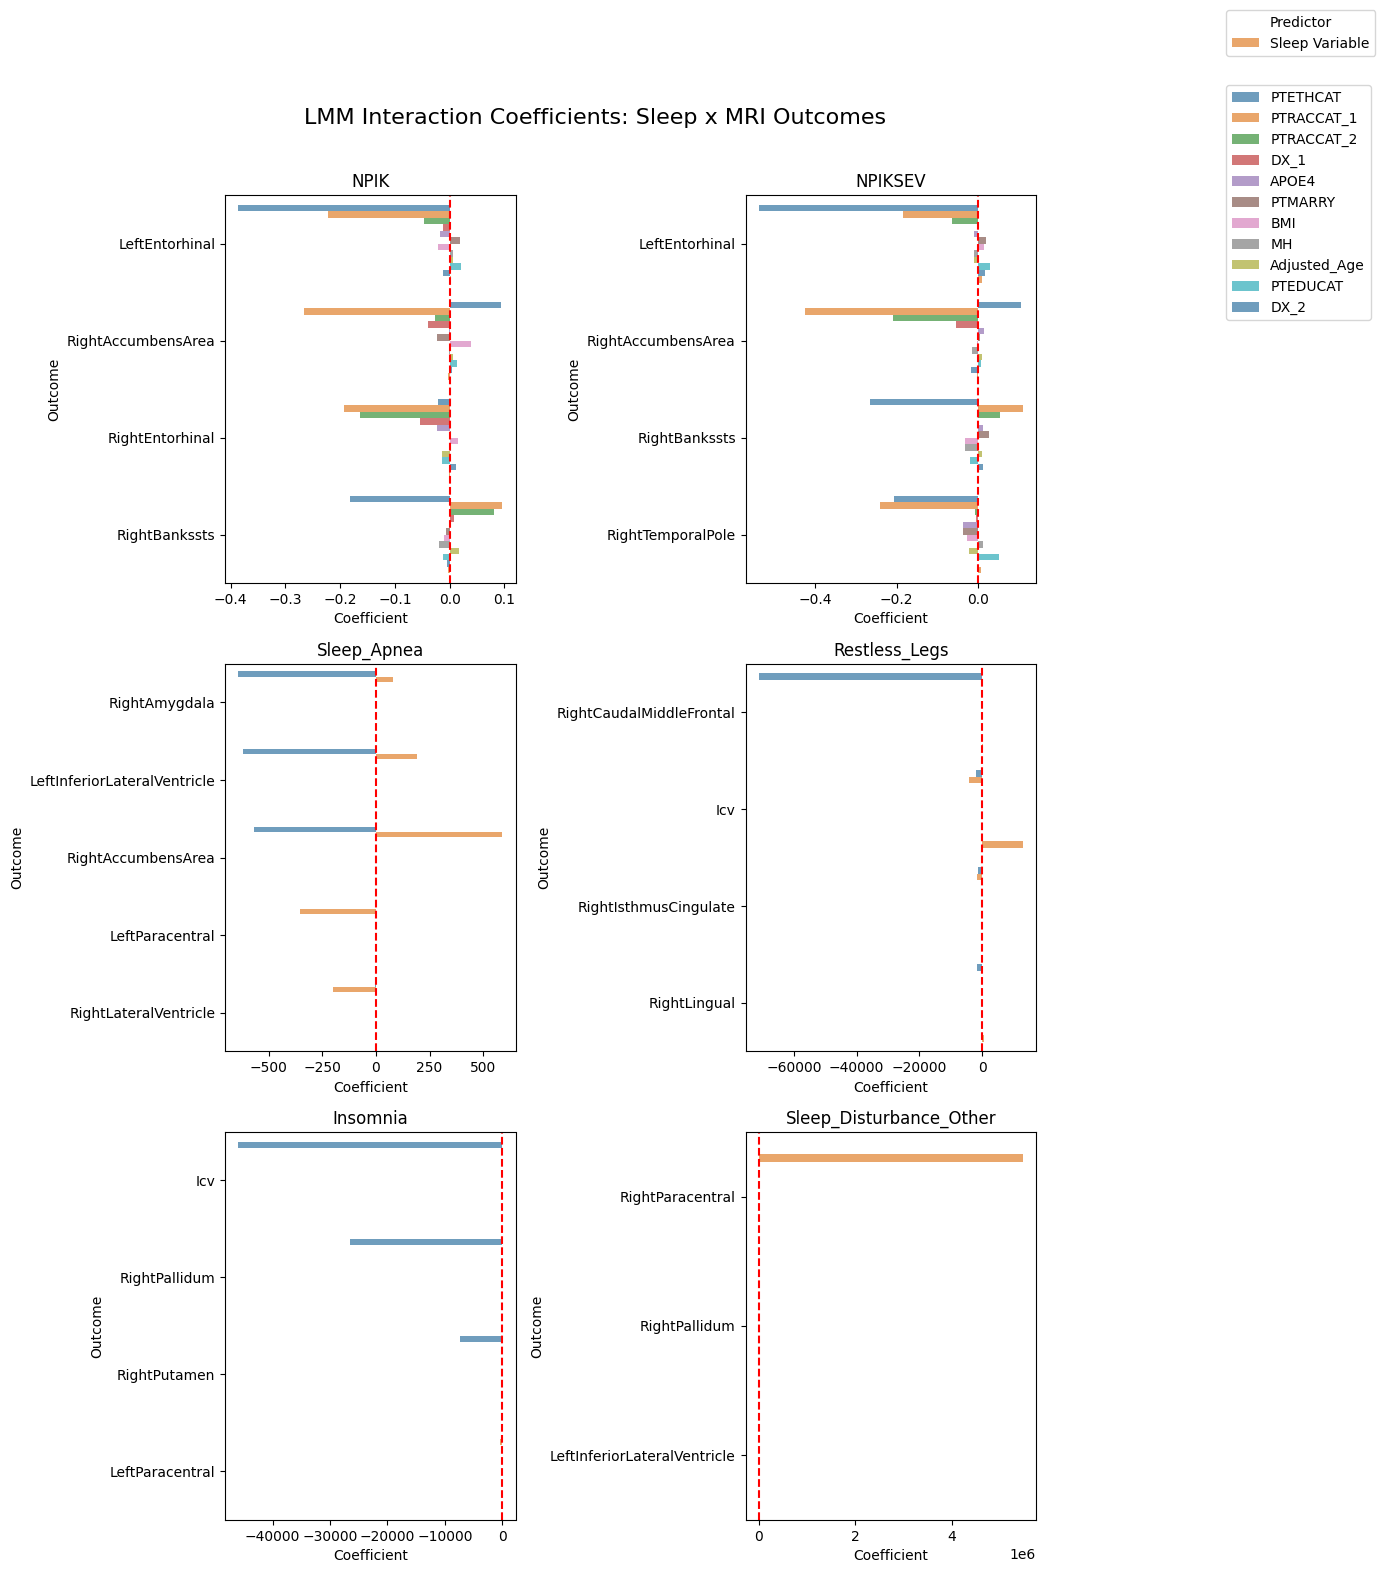

In [48]:
plot_interaction_lmm(df_top_all, model='Model2_MRI', domain='MRI')